# Style transfer

We have seen that CNN's are some of the most powerful networks for image classification and analysis. CNN's process visual information in a feed forward manner, passing an input image through a collection of image filters which extract certain features from the input image. It turns out that these feature level representations are not only useful for classification, but for image construction as well. These representations are the basis for applications like Style Transfer and Deep Dream, which compose images based on CNN layer activations and extracted features. 

In this module we will focus on learning about and implementing the style transfer algorithm. Style transfer allows us to apply the style of one image to another image of our choice. The key to this technique is using  atrained CNN to separate the content from the style of an image. If we can do this then we can merge the content of one image with the style of another and create sometnhing entirely different. 

Let's talk about how style and content can be separated and by the end of this notebook, we will have all the knowledge we need to generate a stylized image of our own design. 

# Separating Style and Content

When a CNN is trained to classify images, its convolutional layers learn to extract more and more complex features from a given image. Intermittently max pooling layers will discard detailed spatial information, information that is increasingly irrelevant to the task of classification. The effect of this is that as we go deeper into a CNN, the input image is transformed into feature maps that increasingly care about the content of the image rather than any detail about the texture and color of pixels. Later layers of a network are even sometimes referred to as a content representation of an image. 

<img src="assets/CNNTrainingFlow.png">

In this way a trained CNN has already learned to represent the content of an image, but what about style? Style can be thought of as traits that might be found in the brush strokes of a painting, its texture, colors, curvature, and so on. To perform style transer, we need to combine the content of one image with the style of another. So, how can we isolate only the style of an image? 

To represent the style of an input image, a feature space designed to capture texture and color information is used. This space essentially looks at spatial correlations within a layer of a network. A correlation is a measure of the relationship between two or more variables. For example, we could loot at the features extracted in the first convolutional layer which has some depth. The depth corresponds to the number of frature maps in that layer. For each feature map, wwe can measure how strongly its detected features relate to the other feature maps in that layer. Is a certain color detected in one map similar to a color in another map? What about the differences between detected edges and corners, and so on? 

See which colors and shapes in a set of feature maps are related and which are not. Say, we detect that mini-feature maps in the firt convolutional layer have similar pink edge features. If there are common colors and shapes among the feature maps, then this can be thought of as part of that image's style. So, the similarities and differences between features in a layer should give us some information about the texture and color information found in an image. But at the same time, it should leave out information about the actual arrangement and identity of different objects in that image. 

Now, we have seen that content and style can be separate components of an image. Let's think about this in a complete style transfer example. Style transfer will look at two different images. We often call these the style image and the content image. Using a trained CNN, style transfer finds the style of one image and the content of the other. Finally, it tries to merge the two to create a new third image. In this newly created image, the objects and their arrangement are taken from the content image, and the colors and textures are taken from the style image.

This is the theory behind how style transfer works. Next, let's talk more about how we can actually extract features from different layers of a trained model and use them to combine the style and content of two different images. 

# VGG19 and Content Loss

In the code example that we will go through, we will recreate a style transfer method that is outlined in the paper, image style transfer using convolutional neural networks. In this paper, style transfer uses the features found in the 19 layers of VGG network, which we will call VGG19. This network accepts a color image as input and passes it through a series of convolutional and pooling layers. Followed finally by a three fully connected layers but classify the past in image. In-between the five pooling layers, there are stacks of two or four convolutional layers. The depth of these layers is standard within each stack, but increases after each pooling layer. They are named by stack and their order in the stack. Conv1_1 is the first convolutional layer that an image is passed throughin the first stack. Conv2_1 is the first convolutional layer in the second stack. the deepest convolutional layer in the network is conv5_4.

<img src="assets/VGG19_layers.png">

Now, we know that style transfer want to create an image that has the content of one image and the style of another. To create the Content image, which we will call our target image, it will first pass both the content and style images through the VGG19 network. 

First, when the network sees the content image, it will go through the feed-forward process until it gets to a convolutional layer that is deep in the network. The output of this layer will be the content representation of the input image. 

<img src="assets/ContentImageVGG19.png">

Next, when it sees the style image, it will stract different features from multiple layers that represent the style of that image. 

<img src="assets/StyleImageVGG19.png">

Finally, it will use both the content and style representations to inform the creation of the target image. The challenge is how to create the target image. How can we take a target image which often starts as either a blank canvas or as a copy of our content image, and manipulate it so that its content is close to that of our content image, and its style is close to that of our style image? 

Let's start by discussing in the content. In the paper, the content representation for an image is taken as the output from the fourth convolutional stack conv4_2. As we form our new target image, we will compare its content representation with that of our content image. These two representations should be close to the same even as our target image changes its style. 

To formalize this comparison, we will define a content loss, a loss that calculates the difference between the content and target image representations, which we will call CC and TC respectively. In this case, we calculate the mean squared difference between the two represeentations. This is our content loss, and it measures how far away these two representations are from one another. 

<img src="assets/ContentLoss.png">

As we try to create the best target image, our aim will be to minimize this loss. This is similar to how we used loss and optimization to determine the weights of a CNN during training. But this time, our aim is not to minimize classification error. In fact, we are not training the CNN at all. Rather our goal is to change only the target image, updating its appearance until its content representation matches that of our content image. 

So we are not using the VGG19 network in a traditional sense, we are not training it to produce a specific output. But we are using it as a feature extractor, and using backpropagation to minimize a defined loss function between our target and content images. In fact, we will have to define a loss function between our target and style images, in order to produce an image with our desired style. Next, let's learn more about how to represent the style of an image.

### An Useful Resource: [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

# Gram Matrix

To make sure that our target image has the same content as our content image, we formalize the idea of a content loss, that compares the content representations of the two images. Next, we want to do the same thing for the style repreesentations of our target image and style image. The style representation of an image relies on looking at correlations between the features in individual layers of the VGG19 network. In other words, looking at how similar the features in a single layer are. Similarities will include the general colors and textures found in that layer. 

We typically find the similarities between features in multiple layers in the network. By including the correlations between multiple layers of different sizes, we can obtain a multiscale style representation of the input image, one that captures large and small style features. 

<img src="assets/MultiscaleCNN.png">

The style representation is calculated as an image passes through the network at the first convolutional layer in all five stacks, conv1_1, conv2_1, up to conv5_1.

The correlations at each layer are given by a gram matrix. The matrix is a result of a couple of operations, and it is easiest to see in a simple example. Say we start off with a 4x4 image, and we convolve it with eight different image filters to create a convolutional layer. This layer will be 4x4 in height and width, and 8 in depth. Thinking about the style representation for this layer, we can say that this layer has eight feature maps that we want to find the relationships between. 

The first step in calculating the Gram matrix, will be to vectorize the values in this layer. This is very similar to what we have seen before, in the case of veectorizing an image so that it can be seen by an NLP. The first row of 4 values in the feature map, will become the first four values in a vector with length 16. The last row will be the last four values in that vector. 

<img src="assets/GramVectorizing.png">

By flattening the X, Y dimensions of the feature maps, we are converting a 3D convolutional layer into a 2D matrix of values. The next step is to multiply this matrix by its transpose. Essentially, by multiplying the features in each map to get the gram matrix. This operation threats each value in the feature map as an individual sample, unrelated in space to other values. So, the resultand Gram matrix contains non-localized information about the layer. Non-localized information, is information that would still be there even if an image was shuffled around in space. For example, even if the content of a filtered image is not identifiable, we should still be able to see prominent colors and texture the style. 

<img src="assets/SecondStepGram.png">

Finanlly, we are left with the square 8x8 Gram Matrix, whose values indicate the similarities between the layers.

So, F row 4x2, will hold a value that indicates the similarity between the fourth and second feature maps in a layer.
Importantly, the dimensions of this matrix are related only to the number of feature maps in the convolutional layer, it doesn't depend on the dimensions of the input image. 

<img src="assets/ResultGramExample.png">

We should note that the Gram matrix is just one mathematical way of representing the idea of shared in prominent styles. Style itself is an abstract idea but the Gram matrix is the most widely used in practice. 

<img src="assets/QuizGramMatrix.png">
Yes! When the height and width (8 x 8) are flattened, the resultant 2D matrix will have as many columns as the height and width, multiplied: 
$8*8 = 64$

<img src="assets/QuizGramMatrix2.png">
Yes! The Gram matrix will be a square matrix, with a width and height = to the depth of the convolutional layer in question.

Now that we have deifned the Gram matrix as having information about the style of a given layer, next we can calculate a style loss that compares the style of our target image and our style image. 

# Style loss

To calculate the style loss between a target and style image, we find the mean squared distance between the style and target image gram matrices, all five pairs that are computed at each layer in our predefined list, conv1_1 up to conv5_1.

<img src="assets/StyleLoss.png">

These lists, we will call SS and TS and A is a constant that accounts for the number of values in each layer. We multiply these five calculated distances by some style weights W that we specify, and then add them up. The style weights are values that will give more or less weight to the calculated style loss at each of the five layer, thereby changing how much effect each layer style representation will have on our final target image. Again, we will only be changing the target image's style representations as we minimize this loss over some number of iterations. 

<img src="assets/StyleLossFormula.png">

So now we have the content loss, which tell us how close the content of our target image is to that of our content image, and the style loss, which tell us how close our target is in style to our style image. We can now add these losses together to get the total loss, and then use typical back propagation and optimization to reduce this loss by iteratively changing the target image to match our desired content and style. 

<img src="assets/TotalLoss.png">

# Loss Weights

Before we move on to coding, we should mention one more detail about the total style transfer loss. We have values for the content and style loss, but because they are calculated differently, these values will be pretty different, and we want our target image to take both into account fairly equally. So, it is necessary to apply constant weights, alpha and beta, to the content and style losses, such that the total loss reflects an equal balance. 

In practice this means multiplying the style loss by a much larger weight value thatn the content loss. We will often see this expressed as a ratio of the content and style weights, alpha over beta. In the paper, we see the effects of a bigger or smaller ratio. 

<img src="assets/LossWeights.png">

Let's imagine an example of content and Style image, we can imagine that the content weight alpha is one, and that the style weight beta is 10. 

<img src="assets/LossWeightExample.png">

We can see that this target image is mostly content without much style, but as beta increases to 100, then 1000, and alpha stays at one, we can see more and more style in the generated image. Finally, we see that this can go too far, and at a radio of $10^{-4}$ we see that most of the content is gone, and only style remains. 

<img src="assets/LossWeightExample2.png">

So, in general, the smaller the alpha-beta ratio, the more stylistic effect we will see. This makes intuitive sense because a smaller ratio corresponds to a larger value for beta, the style weight. We may find that certain ratios work well for one image, but not another. These weights will be good values to change to get the exact kind of stylized effect that we want. 

All right. Now that we know the theory and math behind using a pretrained CNN to separate the content and style of an image, next, we will see how to implement style transfer in PyTorch. 

# Style Transfer with Deep Neural Networks


We’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='assets/vgg19_convlayers.png' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='assets/style_tx_cat.png' width=80% />

We'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. We will be able to upload images of our own and really customize our own target image. 

We will start loading in our usual libraries including a new one, the PIL image library. This will help us load in any kind of image we want to. Next, we want to load in the pretrained VGG19 network that this implementation relies on. 

In [1]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

Using pytorch models, we can load this network in by name and ask for it to be pretrained. We actually just want to load in all the convolutional and pooling layers, which in this case are named features, and this is unique to the VGG network. We may remember doing something similar in the transfer learning notebook.

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Now, VGG becomes as kind of fixed feature extractor, which is just what we want for getting content and style features later. Next, we are going to check if a GPU device is available, and if it is, we move our model to it.

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

We can load in any images we want! Below, we've provided a helper function for loading in any type and size of image. The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Then, we are going to actually load in style and content images form our images directory. We also reshaping our style image into the same shape as the content image. This reshaping step is just going to make the math nicely lined up later on. 

In [5]:
# load in content and style image
content = load_image('assets/images/octopus.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('assets/images/hockney.jpg', shape=content.shape[-2:]).to(device)

Then above, we also have a function to help us convert a normalized tensor image back into a numpy image for display, it show us the images that we chose.

In [6]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

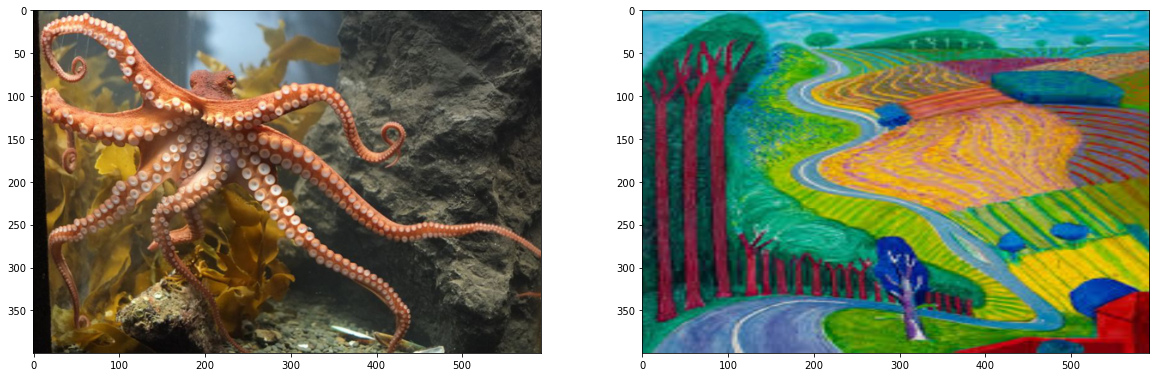

In [7]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [7]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

#### TODO: complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

The first layer (0) to `conv1_1` has been done for you, below.

In [8]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', # Content representation
                  '28': 'conv5_1'}
        
        
    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size()`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

*Note: We can multiply two matrices using `torch.mm(matrix1, matrix2)`.*

#### TODO: Complete the `gram_matrix` function.

In [11]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    ## get the batch_size, depth, height, and width of the Tensor
    # We can ignore batch size because we are interested in the depth or number of feature maps, height and width.
    #batch_size, d, h, w = tensor.size() 
    _, d, h, w = tensor.size()
    ## reshape it, so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w) # a 2D shape that has its spatial dimensions flattened.
    #It retains the number of feature maps as the nummber of rows.
    ## calculate the gram matrix
    # This effectively multiplies all the features and gets the correlations. 
    gram = torch.mm(tensor, (torch.transpose(tensor, 0, 1)))
    
    return gram 

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In the next cell, we are calling `get_features` on our content image passing in our content image and the VGG model, and we do the same thing for our style features, ppassing on our style image and the VGG model. Then we calculate all the gram matrices for each of our style layers conv1_1 up to conv5_1, that looks at all of the layers in our style features and computes the gram matrix. Then it returns a dictionary where we can call style grams with a diven layer name and get the gram matrix for that layer. Finally, we create a target image. We could start with a blank slate, but it turns out to be easier to just start with a clone of the conten image. This way, our image will not divert to far from our content and our plan will be to iterate and change that image to stylize it more and more later. We are going to set `requires_grad_`to true, and we will move it to a GPU if available.

In [12]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

Below, we are given the option to weight the style representation at each relevant layer. It's suggested to use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, we can expect to get _larger_ style artifacts in our resulting, target image. Should we choose to weight later layers, we'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

Notice that conv4_2 is excluded here. These are just weights that are going to give one set of style features more importance than anothers. Remember the radio that makes sure that style and content are equally important in the target image creation process. Because of how style loss is calculated, we basically want to give our style loss a much larger weight than the content loss. 

In [13]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses

We'll decide on a number of steps for which to update your image, this is similar to the training loop that we've seen before, only we are changing our _target_ image and nothing else about VGG19 or any other image. Therefore, the number of steps is really up to us to set! **We recommend using at least 2000 steps for good results.** But, we may want to start out with fewer steps if we are just testing out different weight values or experimenting with different images.

Inside the iteration loop, you'll calculate the content and style losses and update your target image, accordingly.

#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary `style_weights`. 
> You'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. 
> Later, you'll see that this value is normalized by the size of the layer.

#### Total Loss

Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!

Intermittently, we'll print out this loss; don't be alarmed if the loss is very large. It takes some time for an image's style to change and you should focus on the appearance of your target image rather than any loss value. Still, you should see that this loss decreases over some number of iterations.

#### TODO: Define content, style, and total losses.

In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    ## TODO: get the features from your target image    
    ## Then calculate the content loss
    target_features = None
    content_loss = None
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        ## TODO: Calculate the target gram matrix
        target_gram = None
        
        ## TODO:  get the "style" style representation
        style_gram = None
        ## TODO: Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = None
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    ## TODO:  calculate the *total* loss
    total_loss = None
    
    ## -- do not need to change code, below -- ##
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

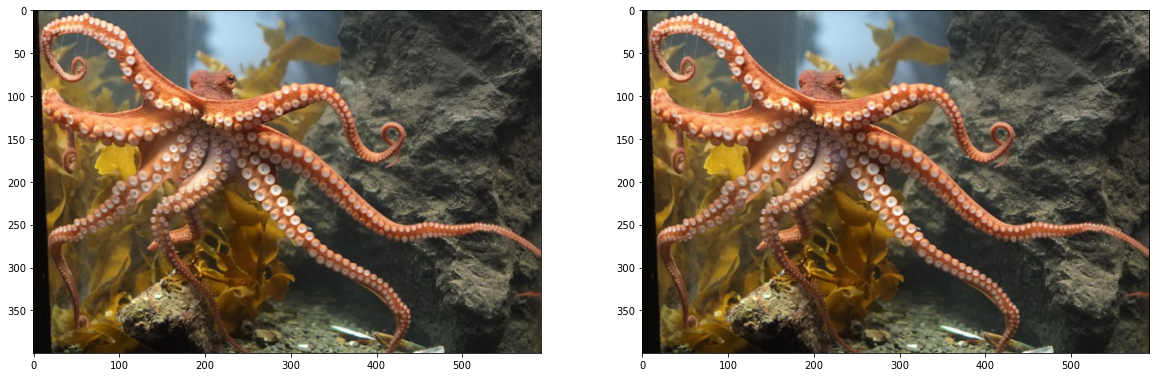

In [14]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))